AIM: To perform topic modelling.

In [ ]:
# install required library
!pip install pyLDAvis

In [ ]:
# import libraries
from google.colab import drive
import pandas as pd
import os

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [ ]:
# mount google drive and connect working directory
drive.mount('/content/gdrive', force_remount = True)
print (sorted(os.listdir('gdrive/My Drive/Colab Helper/ICData/Dataset')))
os.chdir('gdrive/My Drive/Colab Helper/ICData/Dataset') # Connect to the directory

Mounted at /content/gdrive
['data_file.csv', 'test_.csv', 'train_.csv', 'valid_.csv']


In [ ]:
# read train file and print it's shape
traindf = pd.read_csv('train_.csv', usecols=['text','intent'])
print('Train Shape: ', traindf.shape)

Train Shape:  (9951, 2)


**Observation:**

1.   No NULL value present.

In [ ]:
# NULL value presence check
print('NULL values: ', traindf['text'].isnull().sum())

NULL values:  0


**Observation:**

1.   Texts may not require a lot of text cleaning.

In [ ]:
# display first 10 rows
print('First 10 rows:\n', traindf['text'].head(20))

First 10 rows:
 0                             find under night in-birth
1            book a spot in town in the same area as me
2                                            fimd glory
3          i need a restaurant on july 18th in rose bud
4     book a spot for 4 in oklahoma at south street ...
5     i need to know what the weather will be like i...
6     book a bistro in new zealand in 119 and a half...
7              need a table for nine in east prairie la
8     book a table for mindy and angelita at a resta...
9     find me a table for two at seven somewhere in ...
10    add aprite le finestre to my this is earth  wi...
11          book for 2 at a cafe for burgers in gasport
12    what will the weather be in grand coteau ut at...
13            let me hear the good songs from james iha
14          play red barchetta by blind lemon jefferson
15                     play top-50 peter frampton songs
16                     play music by christian bautista
17    which movie theatre neares

**Text Processing**

1.   Convert to lowercase.
2.   Keep alphanumeric (remove punctuations if any).
3.   Remove stopwords.
4.   Remove words that are only one character.
5.   Perform lemmatization.  



In [ ]:
# randomly display any row
print('Random row (5th):\n', traindf['text'][5])
print('Random row (3000th):\n', traindf['text'][3000])
print('Random row (last):\n', traindf['text'][9950])

Random row (5th):
 i need to know what the weather will be like in gradyville at breakfast  in the state of colorado
Random row (3000th):
 what is the 11 pm forecast for here and far
Random row (last):
 rate this current book five


In [ ]:
# convert to lowercase
traindf['text'] = traindf['text'].apply(lambda x: x.lower())
traindf['text'].head(10)

0                            find under night in-birth
1           book a spot in town in the same area as me
2                                           fimd glory
3         i need a restaurant on july 18th in rose bud
4    book a spot for 4 in oklahoma at south street ...
5    i need to know what the weather will be like i...
6    book a bistro in new zealand in 119 and a half...
7             need a table for nine in east prairie la
8    book a table for mindy and angelita at a resta...
9    find me a table for two at seven somewhere in ...
Name: text, dtype: object

In [ ]:
# keep alphanumeric, i.e., remove punctuations if any
traindf['text'] = traindf['text'].apply(lambda x: re.sub(r'[^\w\s]+', '', x))
traindf['text'].head(10)

0                             find under night inbirth
1           book a spot in town in the same area as me
2                                           fimd glory
3         i need a restaurant on july 18th in rose bud
4    book a spot for 4 in oklahoma at south street ...
5    i need to know what the weather will be like i...
6    book a bistro in new zealand in 119 and a half...
7             need a table for nine in east prairie la
8    book a table for mindy and angelita at a resta...
9    find me a table for two at seven somewhere in ...
Name: text, dtype: object

In [ ]:
# remove stopwords
stop = set(stopwords.words('english'))
traindf['text'] = traindf['text'].apply(lambda x: " ".join([word for word in x.split() if word not in stop]))
traindf['text'].head(10)

0                                   find night inbirth
1                                  book spot town area
2                                           fimd glory
3                   need restaurant july 18th rose bud
4              book spot 4 oklahoma south street diner
5    need know weather like gradyville breakfast st...
6                book bistro new zealand 119 half days
7                      need table nine east prairie la
8    book table mindy angelita restaurant serves ca...
9             find table two seven somewhere australia
Name: text, dtype: object

In [ ]:
# remove words that are only one character
traindf['text'] = traindf['text'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
traindf['text'].head(10)

0                                   find night inbirth
1                                  book spot town area
2                                           fimd glory
3                   need restaurant july 18th rose bud
4                book spot oklahoma south street diner
5    need know weather like gradyville breakfast st...
6                book bistro new zealand 119 half days
7                      need table nine east prairie la
8    book table mindy angelita restaurant serves ca...
9             find table two seven somewhere australia
Name: text, dtype: object

In [ ]:
# perform lemmatization
lemmatizer = WordNetLemmatizer()
traindf['text'] = traindf['text'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
traindf['text'].head(10)

0                                   find night inbirth
1                                  book spot town area
2                                           fimd glory
3                   need restaurant july 18th rose bud
4                book spot oklahoma south street diner
5    need know weather like gradyville breakfast st...
6                 book bistro new zealand 119 half day
7                      need table nine east prairie la
8    book table mindy angelita restaurant serf café...
9             find table two seven somewhere australia
Name: text, dtype: object

In [ ]:
# randomly display any row (compare the same rows before text processing)
print('Random row (5th):\n', traindf['text'][5])
print('Random row (3000th):\n', traindf['text'][3000])
print('Random row (last):\n', traindf['text'][9950])

Random row (5th):
 need know weather like gradyville breakfast state colorado
Random row (3000th):
 11 pm forecast far
Random row (last):
 rate current book five


**Topic Modelling:**

In [ ]:
# tokenization (corpus creation)
doc_clean_tokens = [row.split() for row in traindf['text']]
print('Tokens:\n', doc_clean_tokens)

Tokens:
 [['find', 'night', 'inbirth'], ['book', 'spot', 'town', 'area'], ['fimd', 'glory'], ['need', 'restaurant', 'july', '18th', 'rose', 'bud'], ['book', 'spot', 'oklahoma', 'south', 'street', 'diner'], ['need', 'know', 'weather', 'like', 'gradyville', 'breakfast', 'state', 'colorado'], ['book', 'bistro', 'new', 'zealand', '119', 'half', 'day'], ['need', 'table', 'nine', 'east', 'prairie', 'la'], ['book', 'table', 'mindy', 'angelita', 'restaurant', 'serf', 'café', 'liégeois'], ['find', 'table', 'two', 'seven', 'somewhere', 'australia'], ['add', 'aprite', 'le', 'finestre', 'earth', 'wind', 'fire', 'playlist'], ['book', 'cafe', 'burger', 'gasport'], ['weather', 'grand', 'coteau', 'ut', 'six', 'pm'], ['let', 'hear', 'good', 'song', 'james', 'iha'], ['play', 'red', 'barchetta', 'blind', 'lemon', 'jefferson'], ['play', 'top50', 'peter', 'frampton', 'song'], ['play', 'music', 'christian', 'bautista'], ['movie', 'theatre', 'nearest', 'showing', 'animated', 'movie', 'starting'], ['add', 'su

In [ ]:
# creating the term dictionary of our courpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(doc_clean_tokens)
print('Dictionary info: ', dictionary)

Dictionary info:  Dictionary(8935 unique tokens: ['find', 'inbirth', 'night', 'area', 'book']...)


In [ ]:
# converting list of documents (corpus) into Document Term Matrix (Bag of Words) using dictionary prepared above
doc_bow = [dictionary.doc2bow(doc) for doc in doc_clean_tokens]
print('Document Term Matrix: ', doc_bow)

Document Term Matrix:  [[(0, 1), (1, 1), (2, 1)], [(3, 1), (4, 1), (5, 1), (6, 1)], [(7, 1), (8, 1)], [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)], [(4, 1), (5, 1), (15, 1), (16, 1), (17, 1), (18, 1)], [(12, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)], [(4, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)], [(12, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1)], [(4, 1), (13, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1)], [(0, 1), (36, 1), (42, 1), (43, 1), (44, 1), (45, 1)], [(46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1)], [(4, 1), (54, 1), (55, 1), (56, 1)], [(25, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1)], [(62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1)], [(68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1)], [(67, 1), (72, 1), (74, 1), (75, 1), (76, 1)], [(72, 1), (77, 1), (78, 1), (79, 1)], [(80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 1)], [(46, 1), (52, 1), (86, 1), (87, 1), (88, 1), (

In [ ]:
# human readable format of corpus (term-frequency)
[[(dictionary[id], freq) for id, freq in x] for x in doc_bow[:5]]

[[('find', 1), ('inbirth', 1), ('night', 1)],
 [('area', 1), ('book', 1), ('spot', 1), ('town', 1)],
 [('fimd', 1), ('glory', 1)],
 [('18th', 1),
  ('bud', 1),
  ('july', 1),
  ('need', 1),
  ('restaurant', 1),
  ('rose', 1)],
 [('book', 1),
  ('spot', 1),
  ('diner', 1),
  ('oklahoma', 1),
  ('south', 1),
  ('street', 1)]]

In [ ]:
# perform topic modelling for 20 topics and plot graph of coherence score
def perform_topic_modelling(model):
  '''
  Function to perform topic modelling and plot graph of coherence scores for given number of topics.

  Parameters:
    model (string): Name of the model, i.e., LSI or LDA

  Return:
    model_list (list): List of trained models for different number of topics.
  '''
  coherence_values = []
  model_list = []
  start, stop, step = 2, 20, 1
  
  # perform topic modelling
  for num_topics in range(start, stop, step):
    if(model=='lsi_model'):
      model = LsiModel(doc_bow, num_topics=num_topics, id2word=dictionary)  # train LSI model
    else:
      model = LdaModel(doc_bow, num_topics=num_topics, id2word=dictionary)  # train LDA model
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=doc_clean_tokens, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

  # display graph
  x = range(start, stop, step)
  plt.figure(figsize=(12,5))
  plt.plot(x, coherence_values)
  plt.xlabel("Number of Topics")
  plt.ylabel("Coherence score")
  plt.legend(("coherence_values"), loc='best')

  return model_list

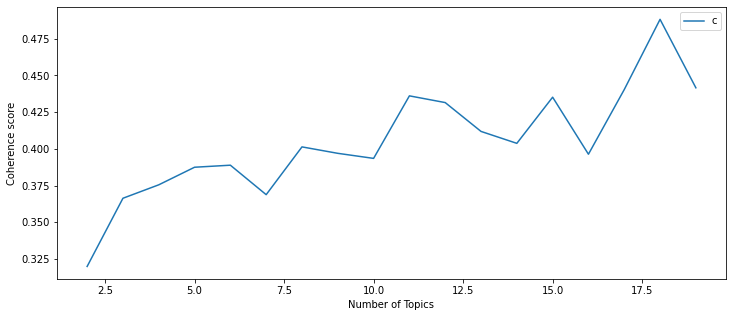

In [ ]:
# topic modelling - LSI Model
model = 'lsi_model'
lsi_model_list = perform_topic_modelling(model)

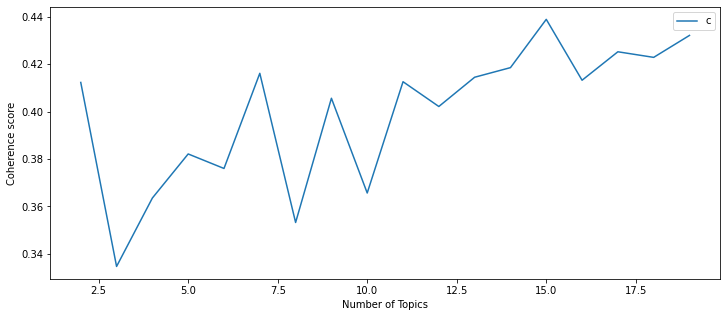

In [ ]:
# topic modelling - LDA Model
model = 'lda_model'
lda_model_list = perform_topic_modelling(model)

In [ ]:
# train LDA model
lda_model = LdaModel(doc_bow, num_topics=7, id2word=dictionary, chunksize=10000, passes=200, iterations=1000) 
# get coherence score
coherence_lda = CoherenceModel(model=lda_model, texts=doc_clean_tokens, dictionary=dictionary, coherence='c_v')
print('Coherence Score: ', coherence_lda.get_coherence())

Coherence Score:  0.37736117188642687


In [ ]:
# print 7 topics of the above trained model
for i, value in enumerate(lda_model.print_topics()):
  print('Topic {}: {}'.format(i, value))

Topic 0: (0, '0.098*"add" + 0.082*"playlist" + 0.035*"song" + 0.019*"tune" + 0.018*"game" + 0.015*"track" + 0.014*"artist" + 0.014*"play" + 0.012*"put" + 0.009*"list"')
Topic 1: (1, '0.070*"find" + 0.017*"called" + 0.013*"like" + 0.012*"saga" + 0.011*"picture" + 0.010*"three" + 0.009*"current" + 0.009*"day" + 0.009*"get" + 0.007*"work"')
Topic 2: (2, '0.089*"book" + 0.050*"restaurant" + 0.037*"table" + 0.030*"need" + 0.025*"reservation" + 0.017*"people" + 0.015*"want" + 0.013*"party" + 0.012*"serf" + 0.012*"spot"')
Topic 3: (3, '0.172*"play" + 0.056*"music" + 0.021*"song" + 0.016*"hear" + 0.015*"want" + 0.012*"top" + 0.010*"album" + 0.010*"last" + 0.010*"track" + 0.009*"twenty"')
Topic 4: (4, '0.065*"rate" + 0.049*"give" + 0.043*"star" + 0.038*"point" + 0.035*"add" + 0.035*"current" + 0.033*"playlist" + 0.025*"album" + 0.021*"book" + 0.017*"rating"')
Topic 5: (5, '0.097*"weather" + 0.063*"forecast" + 0.017*"like" + 0.017*"park" + 0.014*"tell" + 0.012*"state" + 0.012*"going" + 0.011*"is

**Observations:**

1.   4th and 5th topic overlapping - reason for low coherence score.
2.   4th and 5th topic could be PlayMusic and AddToPlaylist.



In [ ]:
# model vizualization
print('Model Visualization\n')
gensimvis.prepare(lda_model, doc_bow, dictionary)

Model Visualization



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.175106  0.100447       1        1  17.734316
2      0.073964  0.243543       2        1  17.693333
6      0.179243 -0.208245       3        1  17.644174
0     -0.195772 -0.071219       4        1  12.708601
3     -0.153336 -0.099157       5        1  12.175260
1      0.109186 -0.040864       6        1  11.075025
5      0.161821  0.075496       7        1  10.969290, topic_info=         Term         Freq        Total Category  logprob  loglift
72       play  1170.000000  1170.000000  Default  30.0000  30.0000
81      movie   901.000000   901.000000  Default  29.0000  29.0000
46        add   993.000000   993.000000  Default  28.0000  28.0000
25    weather   550.000000   550.000000  Default  27.0000  27.0000
4        book  1019.000000  1019.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1877    sound    18.599151    32.925437   Topic7  -5.7188   1.6389
397      look    22.802591    79.555541   Topic7  -5.5150   0.9605
1510   hotter    17.222336    28.100729   Topic7  -5.7957   1.7205
28        day    18.673402    75.956096   Topic7  -5.7148   0.8070
110     month    17.520629    40.344670   Topic7  -5.7785   1.3760

[373 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
561       2  0.981899       10
701       7  0.979993       16
3633      4  0.962662     1975
333       7  0.904542     2024
1368      7  0.904543     2034
...     ...       ...      ...
226       6  0.137060     year
1123      3  0.942480    young
779       5  0.987424  youtube
578       1  0.990711     zero
686       4  0.989232    zvooq

[450 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 7, 1, 4, 2, 6])

**Conclusion:**

1.   Performed text cleaning.
2.   Performed topic modelling using LSA and LDA for 2 to 20 topics. Plotted coherence score against number of topics.
3.   LDA model tuned for 7 topics by increasing #passes and #iterations. Plotted the model using gensimvis (pyLDAviz).
    *   Coherence score: 0.377
    *   4th and 5th topic overlapping - reason for low coherence score.
    *   4th and 5th topic could be PlayMusic and AddToPlaylist having almost similar terms.
    *   The topics identified as 1 to 7 could be:
        *   Topic 1 - RateBook
        *   Topic 2 - BookRestaurant
        *   Topic 3 - SearchScreeningEvent
        *   Topic 4 - AddToPlaylist
        *   Topic 5 - PlayMusic
        *   Topic 6 - SearchCreativeWork
        *   Topic 7 - GetWeather